In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [6]:
df = pd.read_csv(r"c:\Users\Palan\Desktop\MachineLearning\mainProj\diabetes_prediction_dataset.csv")
print(df.shape, "\n\n", df.dtypes, "\n\n") 
df.head()

(100000, 9) 

 gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object 




,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))
df = df.drop_duplicates()

Number of duplicate rows: 3854


In [4]:
from scipy.stats import chi2_contingency

# Create a contingency table
merged_smoking = df[df['smoking_history'].isin(['ever', 'former', 'not current'])]
contingency = pd.crosstab(merged_smoking['smoking_history'], merged_smoking['diabetes'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"p-value: {p}")


p-value: 8.50333079717086e-32


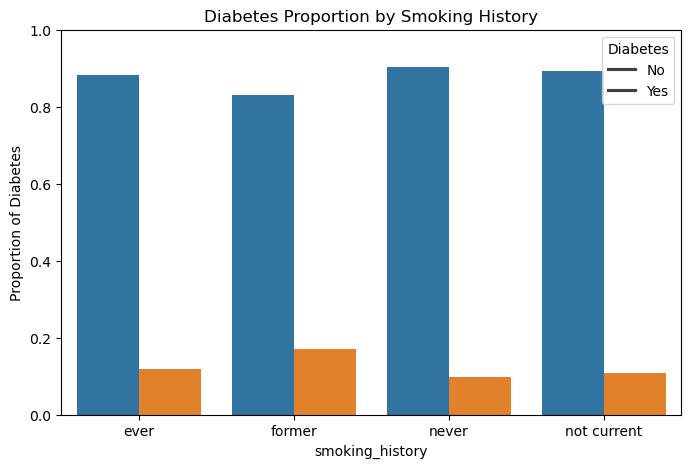

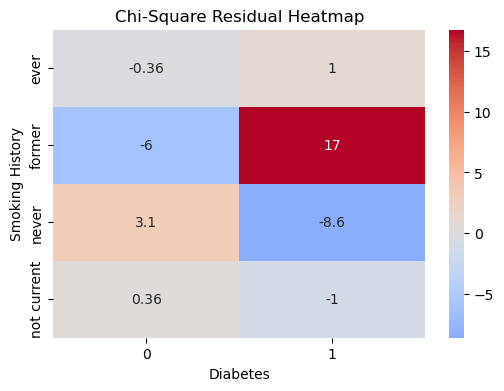

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Filter for 4 smoking categories to compare
subset = df[df['smoking_history'].isin(['ever', 'former', 'not current', 'never'])]

# ==== PROPORTION BARPLOT ====
grouped = subset.groupby(['smoking_history', 'diabetes']).size().reset_index(name='count')

# Normalize within each smoking category
grouped['total'] = grouped.groupby('smoking_history')['count'].transform('sum')
grouped['percentage'] = grouped['count'] / grouped['total']

# Plot grouped bar chart
plt.figure(figsize=(8,5))
sns.barplot(data=grouped, x='smoking_history', y='percentage', hue='diabetes')
plt.ylabel('Proportion of Diabetes')
plt.title('Diabetes Proportion by Smoking History')
plt.ylim(0, 1)
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.show()


# ==== CHI-SQUARE HEATMAP ====
# Create contingency table for chi-square test
contingency = pd.crosstab(subset['smoking_history'], subset['diabetes'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

# Standardized residuals
residuals = (contingency - expected) / expected**0.5

# Plot heatmap of residuals
plt.figure(figsize=(6,4))
sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0)
plt.title('Chi-Square Residual Heatmap')
plt.xlabel('Diabetes')
plt.ylabel('Smoking History')
plt.show()


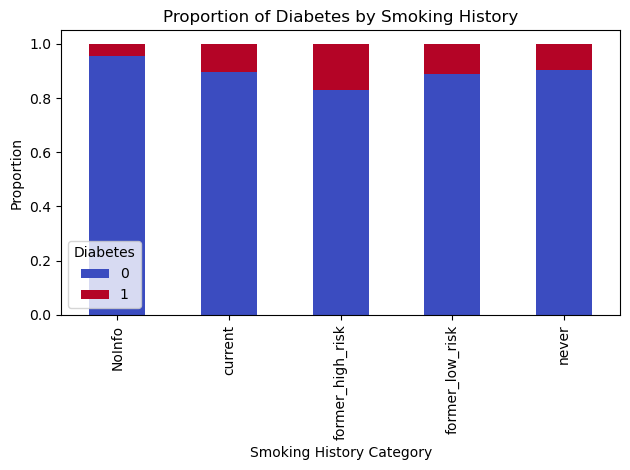

In [6]:
mapping = {
    'former':       'former_high_risk',
    'not current':  'former_low_risk',
    'ever':         'former_low_risk',
    'never':        'never',
    'current':      'current',
    'No Info':      'NoInfo'  # remove the space to avoid key errors later
}

df['smoking_history'] = df['smoking_history'].map(mapping)

# Plot updated proportions
prop_df = df.groupby('smoking_history')['diabetes'].value_counts(normalize=True).unstack()
prop_df.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Diabetes by Smoking History')
plt.ylabel('Proportion')
plt.xlabel('Smoking History Category')
plt.legend(title='Diabetes')
plt.tight_layout()
plt.show()


In [7]:
from math import inf

def early_stop_callback(no_improve_trials):
    # Returns a callback function that stops the study if there is no improvement for `no_improve_trials`.

    best_score = {"value": -inf, "no_improve_count": 0} # -inf so no matter what, the first trial will be better

    def callback(study, trial):
        nonlocal best_score
        if trial.value > best_score["value"]: # Update best score if current trial is better
            best_score["value"] = trial.value # Update the best score
            best_score["no_improve_count"] = 0 # Reset no improvement count
        else:
            best_score["no_improve_count"] += 1  # Increment no improvement count  

        if best_score["no_improve_count"] >= no_improve_trials:
            print(f"Early stopping: No improvement in {no_improve_trials} trials.")
            study.stop()

    return callback


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split first
df_LE = df.copy()
X_LE = df_LE.drop('diabetes', axis=1)
y_LE = df_LE['diabetes']

X_LE_train, X_LE_test, y_LE_train, y_LE_test = train_test_split(
    X_LE, y_LE, test_size=0.2, random_state=42, stratify=y_LE
)

# Fit encoder only on training set to prevent data leakage
le_gender = LabelEncoder()
le_smoking = LabelEncoder()

X_LE_train['gender'] = le_gender.fit_transform(X_LE_train['gender'])
X_LE_train['smoking_history'] = le_smoking.fit_transform(X_LE_train['smoking_history'])

# Transform test set using same mapping
X_LE_test['gender'] = le_gender.transform(X_LE_test['gender'])
X_LE_test['smoking_history'] = le_smoking.transform(X_LE_test['smoking_history'])

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
from sklearn.model_selection import cross_val_score

def objective_hist_gb(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 10)
    
    clf = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        l2_regularization=l2_regularization,
        random_state=42
    )
    
    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_hist_gb = optuna.create_study(direction='maximize')
study_hist_gb.optimize(objective_hist_gb, callbacks=[early_stop_callback(50)])
print("Best average_precision:", study_hist_gb.best_trial.value)
print("Best Params:", study_hist_gb.best_trial.params)

c:\Users\Palan\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-30 11:07:17,193] A new study created in memory with name: no-name-ed7f1e2b-b4d4-45e6-acdd-b866a915f0c5
[I 2025-07-30 11:07:21,699] Trial 0 finished with value: 0.8863689734787806 and parameters: {'max_iter': 201, 'learning_rate': 0.07486165913354553, 'max_depth': 13, 'min_samples_leaf': 18, 'max_leaf_nodes': 26, 'l2_regularization': 9.330228103073493}. Best is trial 0 with value: 0.8863689734787806.
[I 2025-07-30 11:07:24,341] Trial 1 finished with value: 0.8880348401000961 and parameters: {'max_iter': 766, 'learning_rate': 0.18575326055897215, 'max_depth': 15, 'min_samples_leaf': 11, 'max_leaf_nodes': 10, 'l2_regularization': 3.2697179043005686}. Best is trial 1 with value: 0.8880348401000961.
[I 2025-07-30 11:07:26,586] T

Early stopping: No improvement in 50 trials.
Best average_precision: 0.8891419289563249
Best Params: {'max_iter': 824, 'learning_rate': 0.06722665991105782, 'max_depth': 3, 'min_samples_leaf': 5, 'max_leaf_nodes': 45, 'l2_regularization': 5.964809105788984}


In [10]:
from sklearn.metrics import recall_score, classification_report, confusion_matrix

hgb_model = HistGradientBoostingClassifier(
    **study_hist_gb.best_params,
    class_weight="balanced",
    random_state=42
)

hgb_model.fit(X_LE_train, y_LE_train)
hgb_pred = hgb_model.predict(X_LE_test)

print("Final Test Recall:", recall_score(y_LE_test, hgb_pred))
print("---------------------------- classification report ----------------------------")
print(classification_report(y_LE_test, hgb_pred))
print("---------------------------- confusion matrix ----------------------------")
print(confusion_matrix(y_LE_test, hgb_pred))
print("---------------------------- Model fitting test ----------------------------" , "\nTraining data set recall: "  , recall_score(y_LE_train, hgb_model.predict(X_LE_train)), "\nTesting data set recall: ", recall_score(y_LE_test, hgb_pred))

Final Test Recall: 0.9257075471698113
---------------------------- classification report ----------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     17534
           1       0.46      0.93      0.61      1696

    accuracy                           0.90     19230
   macro avg       0.73      0.91      0.78     19230
weighted avg       0.95      0.90      0.91     19230

---------------------------- confusion matrix ----------------------------
[[15693  1841]
 [  126  1570]]
---------------------------- Model fitting test ---------------------------- 
Training data set recall:  0.9302976716769821 
Testing data set recall:  0.9257075471698113


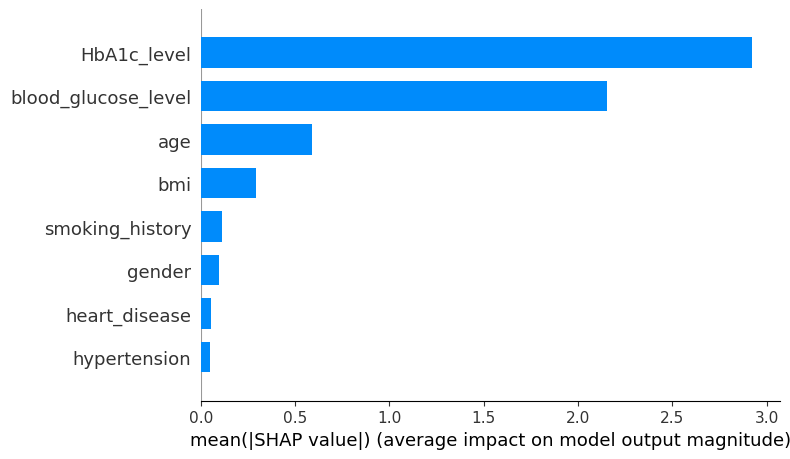

In [11]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Sample the test set
X_sample = X_LE_test.sample(n=1000, random_state=42)

# Step 2: SHAP explainer with additivity check off
explainer = shap.Explainer(hgb_model, X_sample)
shap_values = explainer(X_sample, check_additivity=False)

# Step 3: Bar chart (mean absolute SHAP values)
shap.summary_plot(shap_values, X_sample, plot_type="bar")


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split first
df_LE = df.copy()
X_LE = df_LE.drop('diabetes', axis=1)
y_LE = df_LE['diabetes']

X_LE_train, X_LE_test, y_LE_train, y_LE_test = train_test_split(
    X_LE, y_LE, test_size=0.2, random_state=42, stratify=y_LE
)

# Fit encoder only on training set to prevent data leakage
le_gender = LabelEncoder()
le_smoking = LabelEncoder()

X_LE_train['gender'] = le_gender.fit_transform(X_LE_train['gender'])
X_LE_train['smoking_history'] = le_smoking.fit_transform(X_LE_train['smoking_history'])

# Transform test set using same mapping
X_LE_test['gender'] = le_gender.transform(X_LE_test['gender'])
X_LE_test['smoking_history'] = le_smoking.transform(X_LE_test['smoking_history'])

In [8]:
from sklearn.metrics import recall_score, classification_report, confusion_matrix, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier

# Correct way to pass parameters
gb_model = GradientBoostingClassifier(
    n_estimators=499,
    learning_rate=0.08108684289213029,
    max_depth=5,
    min_samples_split=8,
    min_samples_leaf=1,
    subsample=0.8263504684616676,
    max_features='sqrt'
)

# Fit model
gb_model.fit(X_LE_train, y_LE_train)

# Predict on test data
gb_pred = gb_model.predict(X_LE_test)

# Evaluate
print("Final Test PR-AUC:", average_precision_score(y_LE_test, gb_pred))
print("Final Test Recall:", recall_score(y_LE_test, gb_pred))
print("---------------------------- classification report ---------------------------- \n", classification_report(y_LE_test, gb_pred))
print("---------------------------- confusion matrix ---------------------------- \n", confusion_matrix(y_LE_test, gb_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data set recall:", recall_score(y_LE_train, gb_model.predict(X_LE_train)))
print("Testing data set recall:", recall_score(y_LE_test, gb_pred))


Final Test PR-AUC: 0.6902986716509146
Final Test Recall: 0.6994117647058824
---------------------------- classification report ---------------------------- 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.70      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000

---------------------------- confusion matrix ---------------------------- 
 [[18238    62]
 [  511  1189]]
---------------------------- Model fitting test ----------------------------
Training data set recall: 0.7391176470588235
Testing data set recall: 0.6994117647058824
